# Pythonでチップチューン音楽を作ろう

Pythonで音声波形を操作してチップチューン音楽、いわゆる8bit音楽をつくっていきます。

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import IPython.display as ipd

## チップチューン

ファミコンなどに内蔵されている、制約の多い音源チップによって作られる音楽のことをチップチューンと呼びます。ファミコンのcpuが8bitであったことから、8bit音楽とも呼ばれます。

ファミコンではPSGという種類の音源チップが使われていました。PSG音源では、いくつかの主要な音を組み合わせて音を作り出します。ファミコンでは、次の3種類の音を組み合わせて音を作り出しています。

### 矩形波

*Square Wave*

<u>くけいは</u>（<u>たんけいは</u>じゃないよ）。矩形は長方形という意味です。以下のような波で表します。

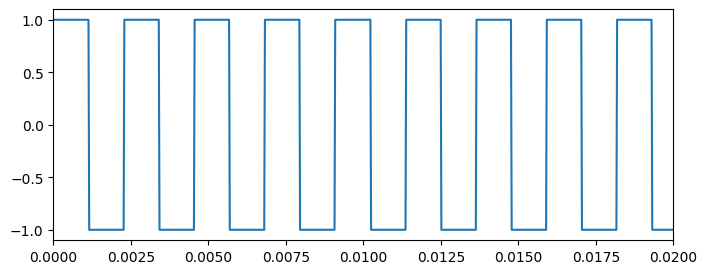

In [2]:
freq, sr, sec = 440, 44100, 1
t = np.arange(0, sec, 1/sr)
y = sp.signal.square(2 * np.pi * freq * t)
plt.figure(figsize=(8, 3))
plt.plot(t, y)
plt.xlim(0, 0.02)
ipd.Audio(y, rate=sr)

矩形波ではデューティー比（疎密の比率）が1:1となっていますが、当然この比率が変わった音も存在します。それらを含めて一般的に**パルス波**と呼んだりもします。

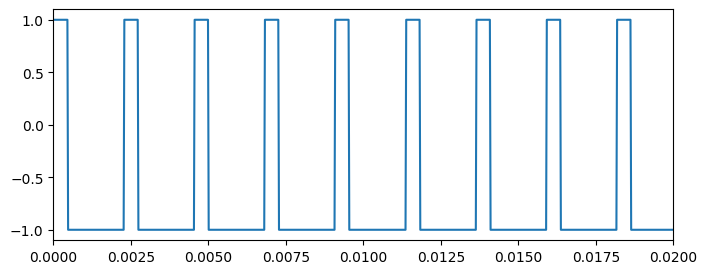

In [3]:
y = sp.signal.square(2 * np.pi * freq * t, duty=0.2)
plt.figure(figsize=(8, 3))
plt.plot(t, y)
plt.xlim(0, 0.02)
ipd.Audio(y, rate=sr)

## 三角波

*Triangle Wave*

以下のような三角形の波です。

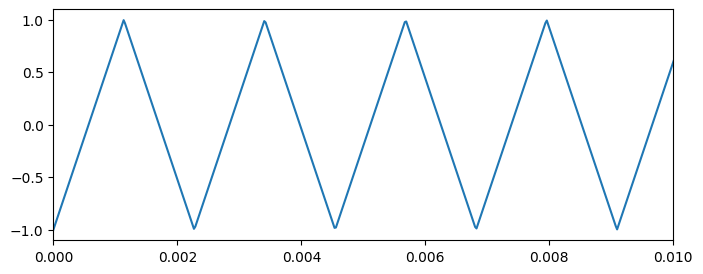

In [4]:
freq, sr, sec = 440, 44100, 1
t = np.arange(0, sec, 1/sr)
y = sp.signal.sawtooth(2 * np.pi * freq * t, width=0.5)
plt.figure(figsize=(8, 3))
plt.plot(t, y)
plt.xlim(0, 0.01)
ipd.Audio(y, rate=sr)

三角形の形を変えた音も存在します。それらも三角波と呼びます。中でも直角三角形を連ねた以下のような波は**ノコギリ波 (Sawtooth Wave)** と呼ばれます。

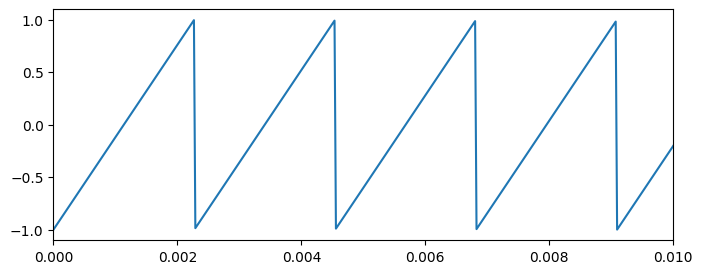

In [5]:
y = sp.signal.sawtooth(2 * np.pi * freq * t)
plt.figure(figsize=(8, 3))
plt.plot(t, y)
plt.xlim(0, 0.01)
ipd.Audio(y, rate=sr)

## ホワイトノイズ

*White Noise*

Official髭男dismの楽曲: [Official髭男dism - ホワイトノイズ [Official Video] - YouTube](https://www.youtube.com/watch?v=_ciQX22n9NE)  
というのは冗談で、ザーっというノイズ音。正規分布や一様分布に従ったサンプルを生成することで作れる。

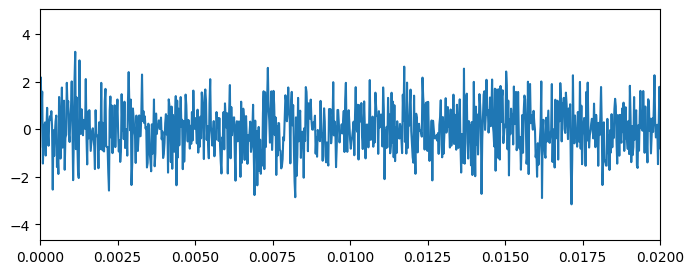

In [6]:
sr, sec = 44100, 1
t = np.arange(0, sec, 1/sr)
y = np.random.randn(len(t))
plt.figure(figsize=(8, 3))
plt.plot(t, y)
plt.xlim(0, 0.02)
ipd.Audio(y, rate=sr)

## Pythonで音を作る

実際に波形を作ってみましょう。

まずはsin波を作ります。最も基本的な音です。純音とも呼ばれます。

まず以下の値を設定します。
- `sr`: サンプリングレート
- `sec`: 秒数
- `freq`: 周波数

In [7]:
sr = 44100
sec = 1.
freq = 440.

次に、時間軸（0から`sec`までを`1/sr`ずつ刻む配列）を作ります。

In [8]:
t = np.arange(0, sec, 1/sr)

最後に、指定した周波数で振動する（1秒あたり`freq`回振動する）sin波を作ります。

(0.0, 0.02)

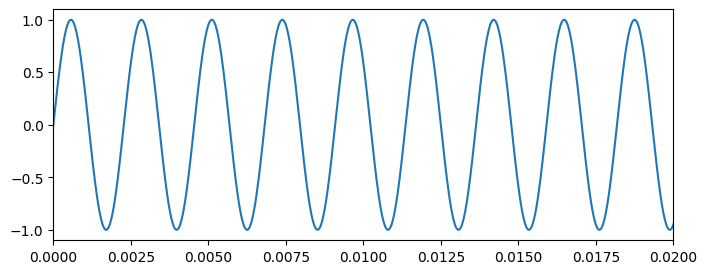

In [9]:
y = np.sin(2 * np.pi * freq * t)

plt.figure(figsize=(8, 3))
plt.plot(t, y)
plt.xlim(0, 0.02)

きれいな波ができました。これを音声ファイルに変換してみましょう。

In [10]:
import soundfile as sf
sf.write('sin.wav', y, sr)

こんな音です。

In [11]:
import IPython.display as ipd
ipd.Audio(y, rate=sr)

これで、1から音を作り出すことができました。

ちなみに、IPython Notebookでは配列を直接音として埋め込むことができます。

In [12]:
ipd.Audio(y, rate=sr)

さて、他の波形も作ってみましょう。といっても、関数を変えるだけですが。

`scipy.signal`に主要な波形が実装されているので、それを使います。

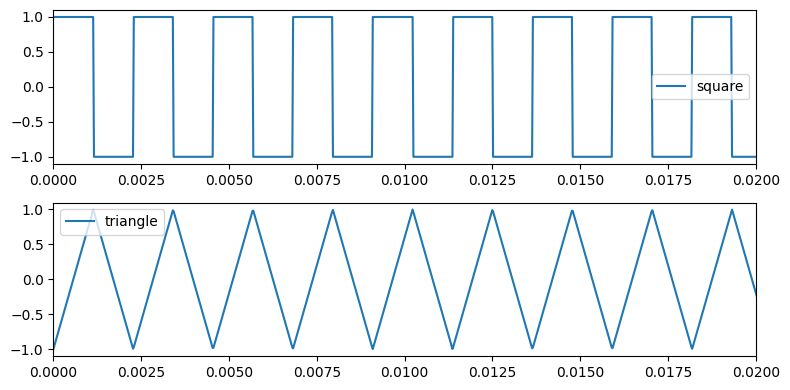

In [13]:
square = sp.signal.square(2 * np.pi * freq * t)
triangle = sp.signal.sawtooth(2 * np.pi * freq * t, width=0.5)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 4))
ax1.plot(t, square, label='square')
ax1.set_xlim(0, 0.02)
ax1.legend()
ax2.plot(t, triangle, label='triangle')
ax2.set_xlim(0, 0.02)
ax2.legend()
fig.tight_layout()

これで完了です。音は先で示した通りです。

## Pythonで音楽を作る

ではいよいよ音楽を作っていきます。

先ほどは音の高さを周波数で指定していましたが、それらを一つ一つ指定するのは面倒です。そこで、音階を数値で指定することとします。  
音階にはMIDIノートナンバーを割り当てます。半音上がるごとに1ずつ増えていく整数値で、例えばC4（ピアノでいう真ん中のド）は60です。

次に、音階と周波数の対応を定義します。ここでは基準としてA4を440Hzとします。

ある音の周波数を2倍にすると、それは1オクターブ上の音になります。オクターブという関係はここから定義されています。この関係を利用して、音階と周波数の対応を次のように定義できます。

$$
freq_n = 440 \times 2^{\frac{n-69}{12}}
$$

$n$はMIDIノートナンバーです。440は基準としたA4の周波数で、69はA4のMIDIノートナンバーです。12は1オクターブの音階の数です。  
実装して確認してみましょう。

In [14]:
def get_freq(n):
    return 440 * 2 ** ((n-69)/12)

n_A4 = 69
n_A5 = 69 + 12
get_freq(n_A4), get_freq(n_A5)

(440.0, 880.0)

ちゃんと$freq_n:freq_{n+12}=1:2$になりましたね。

では、音階を適当に入力してメロディを作ってみましょう。

In [15]:
melody = [60, 62, 64, 65, 67]
sec = 1
sr = 44100
t = np.arange(0, sec, 1/sr)
y = np.array([])
for n in melody:
    freq = get_freq(n)
    y = np.append(y, np.sin(2 * np.pi * freq * t))
ipd.Audio(y, rate=sr)

できましたね。

別のメロディも作ってみましょう。音とその長さをタプルで与えます。また波形も変えてみます。

In [16]:
melody = [
    (79, 0.3), (75, 0.3), (70, 0.3), (75, 0.3), (77, 0.3), (82, 0.6),
    (70, 0.3), (77, 0.3), (79, 0.3), (77, 0.3), (70, 0.3), (75, 0.6)
]
sr = 44100
y = np.array([])
for n, sec in melody:
    freq = get_freq(n)
    t = np.arange(0, sec, 1/sr)
    y = np.append(y, sp.signal.square(2 * np.pi * freq * t))

ipd.Audio(y, rate=sr)

聞き慣れた音楽が出来上がりました。

次は和音を作ってみましょう。和音とは、複数の音を同時に鳴らすことです。単純に複数の波を足すだけで作れます。

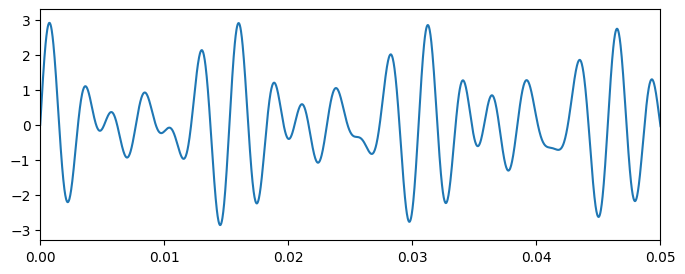

In [17]:
sr = 44100
sec = 1.
n1, n2, n3 = 60, 64, 67
t = np.arange(0, sec, 1/sr)
y = np.zeros_like(t)
for n in [n1, n2, n3]:
    freq = get_freq(n)
    y += np.sin(2 * np.pi * freq * t)

plt.figure(figsize=(8, 3))
plt.plot(t, y)
plt.xlim(0, 0.05)
ipd.Audio(y, rate=sr)

Cメジャーの和音が作れました。

## Pythonでチップチューンを作る

では、これまでの内容を活用してチップチューン音楽を作っていきます。

まずは曲を打ち込むのですが、先ほどのようにMIDIノートナンバーと長さを手動で入力するのは面倒なので、MIDIファイルを読み込めるようにします。music21というライブラリを使います。

- [music21: a Toolkit for Computer-Aided Musicology](https://web.mit.edu/music21/)

In [18]:
import music21 as m21

では作っていきましょう。ドラクエの序曲を打ち込みました。

まずはMIDIの読み込みといくつかの設定です。ファミコンに倣い、2つの矩形波と1つの三角波を使います。

In [19]:
path = 'midi/jokyoku.mid'
midi = m21.converter.parse(path)
sr = 44100
bpm = 120
waveforms = [
    sp.signal.square, # 矩形波
    sp.signal.square, # 矩形波
    lambda t: sp.signal.sawtooth(t, width=0.5), # 三角波
]

次に音を作っていきます。

In [ ]:
tracks = []
for part, waveform in zip(midi[1:], waveforms): # metadata以外の全トラック
    y_track = np.array([])
    for event in part.flatten().notesAndRests: # トラック内の音符と休符
        ql = event.quarterLength # 長さ (4分音符)
        sec = 60 / bpm * ql # 長さ (秒)
        t = np.arange(0, sec, 1/sr) # 時間軸

        if isinstance(event, m21.note.Rest): # 休符
            y_note = np.zeros_like(t) # 音
        else: # 音符
            y_note = np.zeros_like(t)
            for pitch in event.pitches: # 和音を構成する全ての音
                freq = get_freq(pitch.midi) # 周波数
                # freq = pitch.frequency # これでもいい
                y_note = waveform(2 * np.pi * freq * t) # 音

        y_track = np.append(y_track, y_note) # 音を追加
    tracks.append(y_track) # トラックを追加

# 全部足す
y = np.zeros_like(max(tracks, key=len))
for y_track in tracks:
    y[:len(y_track)] += y_track

ipd.Audio(y, rate=sr)

できました。少しベースの音（三角波）が小さいですが...。

別の曲も作ってみましょう。

ここでmunotesというライブラリを導入します。音符の波形を簡単に扱えるライブラリです。私が作りました。紹介記事もあります。
- [munotes: Pythonで音符やコード進行の波形を扱うライブラリ](https://arunote.jp/articles/a2nrkxl1/)

In [21]:
import munotes as mn

こんな感じで音を生成できます。

In [22]:
note = mn.Note("C4")
note.play("square")

では作っていきましょう。今度はポケモン金銀のチャンピオン戦です。

今回は矩形波にエンベロープを指定してみます。

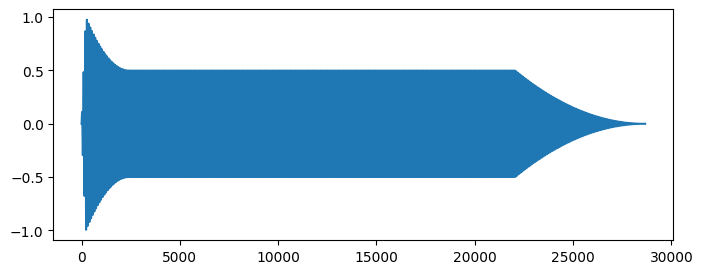

In [23]:
envelope_square = mn.Envelope(
    attack=0.01, decay=0.1, sustain=0.5, release=0.3,
    trans_orders={
        'decay': 2,
        'release': 2,
    }
)
note = mn.Note("C4")
y = note.render(envelope=envelope_square)
plt.figure(figsize=(8, 3))
plt.plot(y);

こんな音です。

In [24]:
note.play(envelope=envelope_square)

では音を作ります。

In [25]:
path = 'midi/pokemon.mid'
bpm = 195

waveforms = ["square", "square", "triangle"]
envelopes = [
    envelope_square,
    envelope_square,
    mn.Envelope(attack=0.01, release=0.02)
]
amps = [1., 0.5, 1.]

In [ ]:
midi = m21.converter.parse(path)
stream = mn.Stream([], unit='ql', bpm=bpm)
for part, waveform, envelope, amp in zip(midi[1:], waveforms, envelopes, amps):
    track = mn.Track([], waveform=waveform, envelope=envelope, amp=amp)
    for event in part.flatten().notesAndRests:
        ql = event.quarterLength
        if isinstance(event, m21.note.Rest):
            track.append(mn.Rest(duration=ql))
        else:
            notes = mn.Notes(
                [note.midi for note in event.pitches],
                duration=ql
            )
            track.append(notes)
    stream.append(track)

stream.play()

コードが少しシンプルになりましたね。音もいい感じです。

## オワリ

以上です。ノイズとかも足していきたいですね。